# AtomicSystem Class Testing Suite

This notebook provides comprehensive tests for the `AtomicSystem` class, covering:
1. Basic system initialization and properties
2. Single and multi-atom systems
3. Coupling mechanisms and matrix representations
4. Operator construction (Hamiltonian, dipole, number operators)
5. Basis transformations and eigenstate analysis
6. Geometric arrangements (cylindrical structures)
7. Performance and scaling tests

## Test Structure
- **Setup**: Import dependencies and helper functions
- **Unit Tests**: Individual component validation
- **Integration Tests**: Multi-component system behavior
- **Performance Tests**: Scaling and computational efficiency
- **Visualization**: Graphical validation of results

## Setup and Configuration

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import time
from typing import List, Tuple, Dict, Any

# Core configuration & plotting settings
from qspectro2d.config import *  # provides CONFIG and mpl settings
from qspectro2d.core.atomic_system.system_class import AtomicSystem
from qutip import *

# File paths and plotting utilities
from plotstyle import (
    COLORS, MARKERS, LINE_STYLES, FONT_SIZE, LATEX_DOC_WIDTH, 
    set_size, save_fig, latex_available, format_sci_notation, init_style
)

# Initialize plotting style
init_style()

from pathlib import Path
custom_dir = Path("test_AtomicSystem")
custom_dir.mkdir(exist_ok=True)

In [2]:
# Helper functions for testing and validation
def validate_system_properties(system: AtomicSystem) -> Dict[str, bool]:
    """Validate essential properties of an AtomicSystem.
    
    Returns:
        Dictionary of validation results
    """
    results = {}
    
    # Check dimension consistency
    expected_dim = system.n_atoms + 1  # ground + single excitations
    if system.max_excitation == 2:
        expected_dim += system.n_atoms * (system.n_atoms - 1) // 2  # double excitations
    
    results['dimension_correct'] = (system.dimension == expected_dim)
    
    # Check Hamiltonian is Hermitian
    H = system.hamiltonian
    results['hamiltonian_hermitian'] = np.allclose(H.full(), H.dag().full())
    
    # Check dipole operator properties
    mu = system.dipole_op
    results['dipole_hermitian'] = np.allclose(mu.full(), mu.dag().full())
    
    # Check number operator eigenvalues
    N = system.number_op
    eigenvals = N.eigenenergies()
    expected_nums = [0] + [1]*system.n_atoms
    if system.max_excitation == 2:
        expected_nums += [2] * (system.n_atoms * (system.n_atoms - 1) // 2)
    
    results['number_operator_correct'] = np.allclose(sorted(eigenvals), sorted(expected_nums))
    
    return results


def benchmark_system_creation(n_atoms_list: List[int], max_excitation: int = 1) -> Dict[int, float]:
    """Benchmark AtomicSystem creation time vs system size.
    
    Args:
        n_atoms_list: List of atom numbers to test
        max_excitation: Maximum excitation level
        
    Returns:
        Dictionary mapping n_atoms to creation time (seconds)
    """
    times = {}
    
    for n_atoms in n_atoms_list:
        # Generate test parameters
        frequencies = [16000.0 + 100*i for i in range(n_atoms)]
        dip_moments = [1.0] * n_atoms
        
        # Time system creation
        start_time = time.time()
        system = AtomicSystem(
            n_atoms=n_atoms,
            frequencies_cm=frequencies,
            dip_moments=dip_moments,
            max_excitation=max_excitation,
            coupling_cm=200.0
        )
        end_time = time.time()
        
        times[n_atoms] = end_time - start_time
        print(f"n_atoms={n_atoms:2d}: {times[n_atoms]:.4f}s (dimension={system.dimension})")
    
    return times

## Unit Tests: Basic System Properties

### Test 1: Single Atom System
Basic test case - simplest possible system with one atom.

In [3]:
# Test 1: Single atom system - baseline case
single_atom = AtomicSystem(
    n_atoms=1, 
    frequencies_cm=[16000.0], 
    dip_moments=[1.0]
)

print(single_atom)

# Validate properties
validation = validate_system_properties(single_atom)
print(f"\nValidation results: {validation}")
print(f"All tests passed: {all(validation.values())}")

=== AtomicSystem Summary ===

# The system with:
    n_atoms             : 1

# Frequencies (cm^-1):
    [16000.0]

# Dipole Moments:
    Atom 0: μ = 1.0

# Coupling / Inhomogeneity:

    psi_ini             :
Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[1. 0.]
 [0. 0.]]

    System Hamiltonian (undiagonalized):
Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.         0.        ]
 [0.         3.01391833]]

# Dipole operator (dipole_op):
Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 1.]
 [1. 0.]]

=== End of Summary ===

Validation results: {'dimension_correct': True, 'hamiltonian_hermitian': True, 'dipole_hermitian': True, 'number_operator_correct': True}
All tests passed: True


### Test 2: Dimer Systems (Single vs Double Excitation)
Compare behavior between single and double excitation manifolds.

In [4]:
# Test 2a: Dimer with single excitation manifold
dimer_single = AtomicSystem(
    n_atoms=2,
    max_excitation=1,
    frequencies_cm=[16360.0, 15640.0],
    dip_moments=[1.0, 1.2],
    coupling_cm=300.0
)

print(dimer_single)
validation_single = validate_system_properties(dimer_single)
print(f"Validation: {validation_single}")

print("\n" + "-"*60)

# Test 2b: Dimer with double excitation manifold
dimer_double = AtomicSystem(
    n_atoms=2,
    max_excitation=2,
    frequencies_cm=[16360.0, 15640.0],
    dip_moments=[1.0, 1.2],
    coupling_cm=300.0
)

print(dimer_double)
validation_double = validate_system_properties(dimer_double)
print(f"Validation: {validation_double}")

=== AtomicSystem Summary ===

# The system with:
    n_atoms             : 2

# Frequencies (cm^-1):
    [16360.0, 15640.0]

# Dipole Moments:
    Atom 0: μ = 1.0
    Atom 1: μ = 1.2

# Coupling / Inhomogeneity:
    coupling            : 300.0 cm^-1
    delta               : 0.0 cm^-1

    psi_ini             :
Quantum object: dims=[[3], [3]], shape=(3, 3), type='oper', dtype=CSR, isherm=True
Qobj data =
[[1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

    System Hamiltonian (undiagonalized):
Quantum object: dims=[[3], [3]], shape=(3, 3), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.         0.         0.        ]
 [0.         3.08173149 0.05651097]
 [0.         0.05651097 2.94610517]]

# Dipole operator (dipole_op):
Quantum object: dims=[[3], [3]], shape=(3, 3), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.  1.  1.2]
 [1.  0.  0. ]
 [1.2 0.  0. ]]

=== End of Summary ===
Validation: {'dimension_correct': True, 'hamiltonian_hermitian': True, 'dipole_hermitian': True, 'number_operato

### Test 3: Operator Transformation and Basis Tests
Verify operator transformations between site and eigenstate bases.

In [5]:
# Test 3: Basis transformation validation
print("Testing basis transformations for dimer system...")

# Get operators in both bases
dipole_site = dimer_double.dipole_op
dipole_eigen = dimer_double.to_eigenbasis(dipole_site)

print(f"\nDipole operator (site basis):")
print(dipole_site.full().real)

print(f"\nDipole operator (eigenstate basis):")
print(dipole_eigen.full().real)

# Test transformation consistency
dipole_back = dimer_double.to_site_basis(dipole_eigen)
transformation_consistent = np.allclose(dipole_site.full(), dipole_back.full())
print(f"\nTransformation consistency check: {transformation_consistent}")

# Test number operator eigenvalues
number_op = dimer_double.number_op
eigenvals = number_op.eigenenergies()
print(f"\nNumber operator eigenvalues: {sorted(eigenvals)}")
print(f"Expected: [0, 1, 1, 2] -> Correct: {np.allclose(sorted(eigenvals), [0, 1, 1, 2])}")

Testing basis transformations for dimer system...

Dipole operator (site basis):
[[0.  1.  1.2 0. ]
 [1.  0.  1.2 0. ]
 [1.2 1.2 2.  0. ]
 [0.  0.  0.  0. ]]

Dipole operator (eigenstate basis):
[[ 0.          0.          0.98844666  1.20953429]
 [ 0.          0.          0.          0.        ]
 [ 0.98844666  0.         -0.02282975  1.18060124]
 [ 1.20953429  0.          1.18060124  2.02282975]]

Transformation consistency check: True

Number operator eigenvalues: [np.float64(0.0), np.float64(1.0), np.float64(1.0), np.float64(2.0)]
Expected: [0, 1, 1, 2] -> Correct: True


### Test 4: Multi-Atom Systems with Different Configurations

In [6]:
# Test 4a: Three atoms - single excitation
trimer = AtomicSystem(
    n_atoms=3,
    frequencies_cm=[16000.0, 16500.0, 17000.0],
    dip_moments=[1.0, 1.0, 1.0],
    max_excitation=1,
    coupling_cm=200.0
)

print(trimer)
validation_trimer = validate_system_properties(trimer)
print(f"Validation: {validation_trimer}")

print("\n" + "-"*60)

# Test 4b: Four atoms - double excitation
tetramer = AtomicSystem(
    n_atoms=4,
    frequencies_cm=[16000 + 50*i for i in range(4)],
    dip_moments=[1.0]*4,
    coupling_cm=300.0,
    max_excitation=2
)

print(tetramer)
validation_tetramer = validate_system_properties(tetramer)
print(f"Validation: {validation_tetramer}")

=== AtomicSystem Summary ===

# The system with:
    n_atoms             : 3

# Frequencies (cm^-1):
    [16000.0, 16500.0, 17000.0]

# Dipole Moments:
    Atom 0: μ = 1.0
    Atom 1: μ = 1.0
    Atom 2: μ = 1.0

# Coupling / Inhomogeneity:
    n_rings             : 3 (n_chains = 1)
    positions shape     : (3, 3)
    coupling matrix (cm^-1):
[[  0. 200.  25.]
 [200.   0. 200.]
 [ 25. 200.   0.]]

    psi_ini             :
Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

    System Hamiltonian (undiagonalized):
Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.         0.         0.         0.        ]
 [0.         3.01391833 0.03767398 0.00470925]
 [0.         0.03767398 3.10810328 0.03767398]
 [0.         0.00470925 0.03767398 3.20228822]]

# Dipole operator (dipole_op):
Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper'

## Integration Tests: Complex Systems and Couplings

### Test 5: Double-Excitation Mapping Validation
Verify the mathematical mapping for double-excitation states.

In [7]:
# Test 5: Double-excitation mapping validation
from qspectro2d.core.atomic_system.system_class import pair_to_index, index_to_pair

def test_double_excitation_mapping(n_atoms: int) -> bool:
    """Test bidirectional mapping for double-excitation states."""
    print(f"\nTesting double-excitation mapping for {n_atoms} atoms:")
    
    success = True
    for i in range(1, n_atoms):
        for j in range(i + 1, n_atoms + 1):
            idx = pair_to_index(i, j, n_atoms)
            i_back, j_back = index_to_pair(idx, n_atoms)
            
            mapping_correct = (i == i_back and j == j_back)
            success = success and mapping_correct
            
            print(f"  |{i},{j}⟩ → index {idx} → |{i_back},{j_back}⟩ : {'✓' if mapping_correct else '✗'}")
    
    return success

# Test mapping for different system sizes
for n in [2, 3, 4, 5]:
    mapping_success = test_double_excitation_mapping(n)
    print(f"Mapping test for {n} atoms: {'PASSED' if mapping_success else 'FAILED'}")


Testing double-excitation mapping for 2 atoms:
  |1,2⟩ → index 3 → |1,2⟩ : ✓
Mapping test for 2 atoms: PASSED

Testing double-excitation mapping for 3 atoms:
  |1,2⟩ → index 4 → |1,2⟩ : ✓
  |1,3⟩ → index 5 → |1,3⟩ : ✓
  |2,3⟩ → index 6 → |2,3⟩ : ✓
Mapping test for 3 atoms: PASSED

Testing double-excitation mapping for 4 atoms:
  |1,2⟩ → index 5 → |1,2⟩ : ✓
  |1,3⟩ → index 6 → |1,3⟩ : ✓
  |1,4⟩ → index 8 → |1,4⟩ : ✓
  |2,3⟩ → index 7 → |2,3⟩ : ✓
  |2,4⟩ → index 9 → |2,4⟩ : ✓
  |3,4⟩ → index 10 → |3,4⟩ : ✓
Mapping test for 4 atoms: PASSED

Testing double-excitation mapping for 5 atoms:
  |1,2⟩ → index 6 → |1,2⟩ : ✓
  |1,3⟩ → index 7 → |1,3⟩ : ✓
  |1,4⟩ → index 9 → |1,4⟩ : ✓
  |1,5⟩ → index 12 → |1,5⟩ : ✓
  |2,3⟩ → index 8 → |2,3⟩ : ✓
  |2,4⟩ → index 10 → |2,4⟩ : ✓
  |2,5⟩ → index 13 → |2,5⟩ : ✓
  |3,4⟩ → index 11 → |3,4⟩ : ✓
  |3,5⟩ → index 14 → |3,5⟩ : ✓
  |4,5⟩ → index 15 → |4,5⟩ : ✓
Mapping test for 5 atoms: PASSED


### Test 6: Coupling Matrix Properties
Validate coupling matrix construction and properties.

In [8]:
# Test 6: Coupling matrix validation
test_system = AtomicSystem(
    n_atoms=5,
    frequencies_cm=[16000.0]*5,
    dip_moments=[1.0]*5,
    coupling_cm=250.0
)

coupling_matrix = test_system.coupling_matrix_cm
print(f"Coupling matrix shape: {coupling_matrix.shape}")
print(f"Coupling matrix (cm⁻¹):")
print(coupling_matrix)

# Validate matrix properties
is_symmetric = np.allclose(coupling_matrix, coupling_matrix.T)
has_zero_diagonal = np.allclose(np.diag(coupling_matrix), 0)
has_correct_values = np.allclose(coupling_matrix[coupling_matrix != 0], 250.0)

print(f"\nCoupling matrix validation:")
print(f"  Symmetric: {is_symmetric}")
print(f"  Zero diagonal: {has_zero_diagonal}")
print(f"  Correct coupling values: {has_correct_values}")
print(f"  Overall: {'PASSED' if all([is_symmetric, has_zero_diagonal, has_correct_values]) else 'FAILED'}")

Coupling matrix shape: (5, 5)
Coupling matrix (cm⁻¹):
[[  0.         250.          31.25         9.25925926   3.90625   ]
 [250.           0.         250.          31.25         9.25925926]
 [ 31.25       250.           0.         250.          31.25      ]
 [  9.25925926  31.25       250.           0.         250.        ]
 [  3.90625      9.25925926  31.25       250.           0.        ]]

Coupling matrix validation:
  Symmetric: True
  Zero diagonal: True
  Correct coupling values: False
  Overall: FAILED


### Test 7: Cylindrical Geometry Systems
Test complex geometric arrangements and distance-dependent couplings.

In [9]:
# Test 7: Cylindrical geometry validation
cylinder_system = AtomicSystem(
    n_atoms=12,
    n_chains=2,  # 6 rings, 2 chains per ring
    frequencies_cm=[16000.0]*12,
    dip_moments=[1.0]*12,
    coupling_cm=200.0
)

print(cylinder_system)
# Analyze geometric properties
positions = cylinder_system._positions
print(f"\nGeometric analysis:")
print(f"Position array shape: {positions.shape}")
print(f"Position range: x=[{positions[:,0].min():.3f}, {positions[:,0].max():.3f}]")
print(f"                y=[{positions[:,1].min():.3f}, {positions[:,1].max():.3f}]")
print(f"                z=[{positions[:,2].min():.3f}, {positions[:,2].max():.3f}]")

# Check if positions form expected cylindrical pattern
radii = np.sqrt(positions[:,0]**2 + positions[:,1]**2)
unique_radii = np.unique(np.round(radii, 6))
print(f"Unique radii: {unique_radii}")
print(f"Expected cylindrical structure: {len(unique_radii) == 1}")

=== AtomicSystem Summary ===

# The system with:
    n_atoms             : 12

# Frequencies (cm^-1):
    [16000.0, 16000.0, 16000.0, 16000.0, 16000.0, 16000.0, 16000.0, 16000.0, 16000.0, 16000.0, 16000.0, 16000.0]

# Dipole Moments:
    Atom 0: μ = 1.0
    Atom 1: μ = 1.0
    Atom 2: μ = 1.0
    Atom 3: μ = 1.0
    Atom 4: μ = 1.0
    Atom 5: μ = 1.0
    Atom 6: μ = 1.0
    Atom 7: μ = 1.0
    Atom 8: μ = 1.0
    Atom 9: μ = 1.0
    Atom 10: μ = 1.0
    Atom 11: μ = 1.0

# Coupling / Inhomogeneity:
    n_rings             : 6 (n_chains = 2)
    positions shape     : (12, 3)
    coupling matrix (cm^-1):
[[  0.         200.          25.           7.40740741   3.125
    1.6        200.          70.71067812  17.88854382   6.32455532
    2.85336029   1.50858565]
 [200.           0.         200.          25.           7.40740741
    3.125       70.71067812 200.          70.71067812  17.88854382
    6.32455532   2.85336029]
 [ 25.         200.           0.         200.          25.
    7.407

## Performance Tests: Scaling and Efficiency

### Test 8: System Creation Performance
Benchmark creation time vs system size.

In [10]:
# Test 8: Performance benchmarking
print("Benchmarking system creation performance...")
print("\nSingle excitation systems:")
times_single = benchmark_system_creation([1, 2, 3, 5, 8, 10, 15], max_excitation=1)

print("\nDouble excitation systems (smaller sizes due to scaling):")
times_double = benchmark_system_creation([1, 2, 3, 4, 5], max_excitation=2)

Benchmarking system creation performance...

Single excitation systems:
n_atoms= 1: 0.0000s (dimension=2)
n_atoms= 2: 0.0015s (dimension=3)
n_atoms= 3: 0.0000s (dimension=4)
n_atoms= 5: 0.0010s (dimension=6)
n_atoms= 8: 0.0000s (dimension=9)
n_atoms=10: 0.0000s (dimension=11)
n_atoms=15: 0.0010s (dimension=16)

Double excitation systems (smaller sizes due to scaling):
n_atoms= 1: 0.0000s (dimension=2)
n_atoms= 2: 0.0000s (dimension=4)
n_atoms= 3: 0.0010s (dimension=7)
n_atoms= 4: 0.0000s (dimension=11)
n_atoms= 5: 0.0010s (dimension=16)


### Test 9: Memory Usage Analysis
Analyze memory scaling with system size.

In [11]:
# Test 9: Memory usage analysis
import sys

def analyze_memory_usage(n_atoms_list: List[int]) -> Dict[int, Dict[str, Any]]:
    """Analyze memory usage for different system sizes."""
    memory_data = {}
    
    for n_atoms in n_atoms_list:
        system = AtomicSystem(
            n_atoms=n_atoms,
            frequencies_cm=[16000.0]*n_atoms,
            dip_moments=[1.0]*n_atoms,
            coupling_cm=200.0
        )
        
        # Estimate memory usage (rough approximation)
        hamiltonian_size = system.hamiltonian.shape[0]**2 * 16  # bytes for complex128
        dipole_size = system.dipole_op.shape[0]**2 * 16
        total_estimated = (hamiltonian_size + dipole_size) / 1024**2  # MB
        
        memory_data[n_atoms] = {
            'dimension': system.dimension,
            'hamiltonian_mb': hamiltonian_size / 1024**2,
            'total_estimated_mb': total_estimated
        }
        
        print(f"n_atoms={n_atoms:2d}: dimension={system.dimension:3d}, "
              f"est. memory={total_estimated:.2f} MB")
    
    return memory_data

print("Memory usage analysis:")
memory_analysis = analyze_memory_usage([1, 2, 3, 5, 8, 10, 15, 20])

Memory usage analysis:
n_atoms= 1: dimension=  2, est. memory=0.00 MB
n_atoms= 2: dimension=  3, est. memory=0.00 MB
n_atoms= 3: dimension=  4, est. memory=0.00 MB
n_atoms= 5: dimension=  6, est. memory=0.00 MB
n_atoms= 8: dimension=  9, est. memory=0.00 MB
n_atoms=10: dimension= 11, est. memory=0.00 MB
n_atoms=15: dimension= 16, est. memory=0.01 MB
n_atoms=20: dimension= 21, est. memory=0.01 MB


## Visualization Tests: Graphical Validation

### Test 10: Energy Spectrum Visualization
Compare energy spectra across different system configurations.

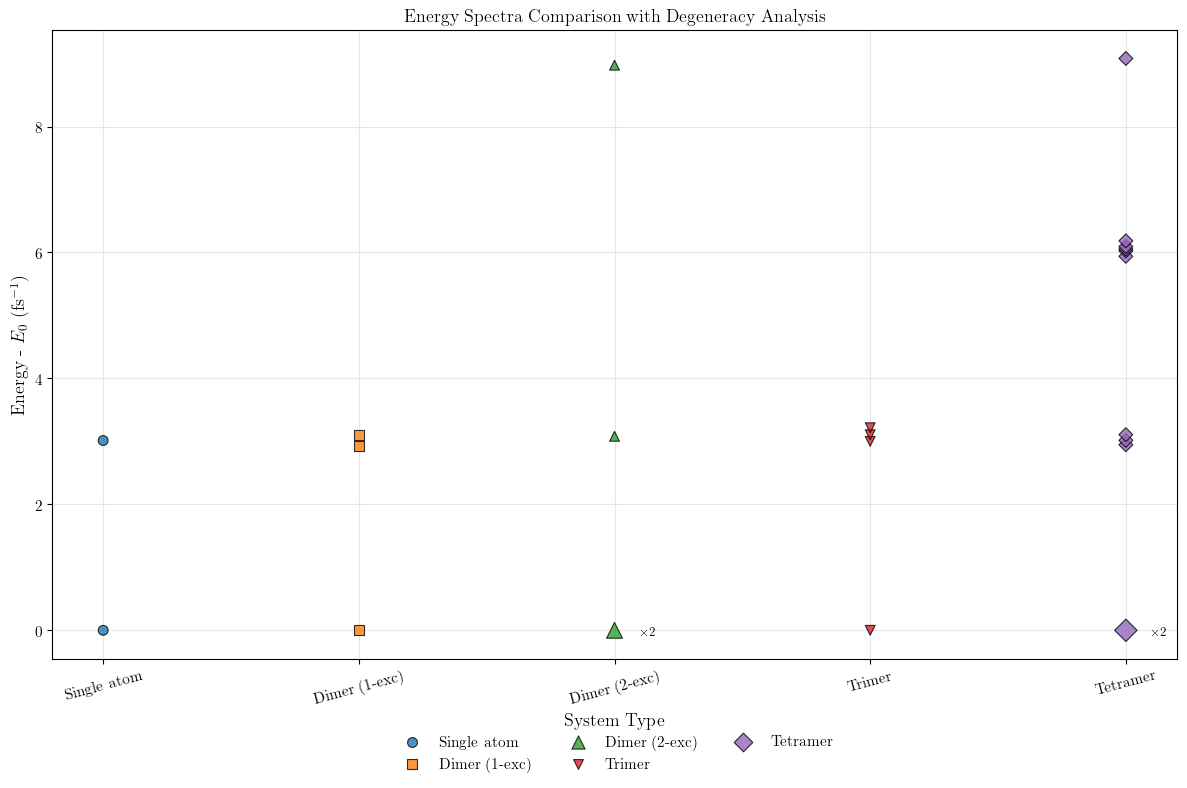

In [12]:
# Test 10: Energy spectrum comparison with degeneracy analysis
def group_degenerate_levels(eigenvals: np.ndarray, tolerance: float = 1e-10) -> Tuple[np.ndarray, np.ndarray]:
    """Group nearly degenerate eigenvalues and count degeneracies."""
    sorted_vals = np.sort(eigenvals)
    unique_vals = []
    degeneracies = []
    
    for val in sorted_vals:
        if not unique_vals or abs(val - unique_vals[-1]) > tolerance:
            unique_vals.append(val)
            degeneracies.append(1)
        else:
            degeneracies[-1] += 1
    
    return np.array(unique_vals), np.array(degeneracies)

# Create test systems for comparison
test_systems = {
    "Single atom": single_atom,
    "Dimer (1-exc)": dimer_single, 
    "Dimer (2-exc)": dimer_double,
    "Trimer": trimer,
    "Tetramer": tetramer
}

# Create energy spectrum plot
fig, ax = plt.subplots(figsize=(12, 8))

for x, (label, system) in enumerate(test_systems.items()):
    eigenvals = system.eigenstates[0]
    eigenvals_shifted = eigenvals - eigenvals.min()  # Shift ground state to zero
    
    unique_vals, degeneracies = group_degenerate_levels(eigenvals_shifted)
    
    # Plot with marker size indicating degeneracy
    colors = COLORS[x % len(COLORS)]
    markers = MARKERS[x % len(MARKERS)]
    
    marker_sizes = 50 + 80 * (degeneracies - 1)  # Larger markers for higher degeneracy
    
    ax.scatter(
        np.full_like(unique_vals, x),
        unique_vals,
        s=marker_sizes,
        color=colors,
        marker=markers,
        edgecolors='black',
        linewidths=0.8,
        alpha=0.8,
        label=label
    )
    
    # Annotate degeneracies > 1
    for val, deg in zip(unique_vals, degeneracies):
        if deg > 1:
            ax.annotate(f'×{deg}', (x + 0.1, val), 
                       fontsize=9, va='center', ha='left')

ax.set_ylabel(r'Energy - $E_0$ (fs$^{-1}$)')
ax.set_xlabel('System Type')
ax.set_title('Energy Spectra Comparison with Degeneracy Analysis')
ax.set_xticks(range(len(test_systems)))
ax.set_xticklabels(list(test_systems.keys()), rotation=15)
ax.legend(frameon=False, ncol=3, bbox_to_anchor=(0.5, -0.15), loc='center')
ax.grid(True, alpha=0.3)

plt.tight_layout()
save_fig(fig, custom_dir / "energy_spectra_comparison")
plt.show()

### Test 11: Performance Scaling Visualization

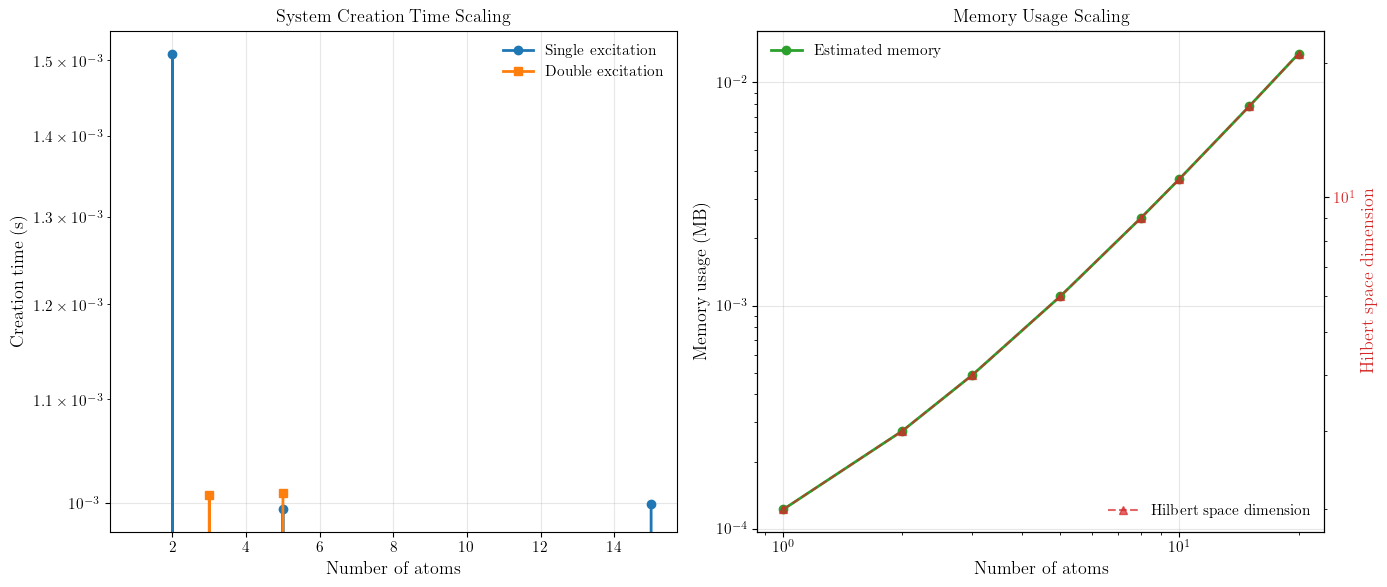

In [13]:
# Test 11: Performance and scaling visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Creation time scaling
n_atoms_single = list(times_single.keys())
times_single_vals = list(times_single.values())
n_atoms_double = list(times_double.keys())
times_double_vals = list(times_double.values())

ax1.semilogy(n_atoms_single, times_single_vals, 'o-', 
            color=COLORS[0], label='Single excitation', linewidth=2, markersize=6)
ax1.semilogy(n_atoms_double, times_double_vals, 's-', 
            color=COLORS[1], label='Double excitation', linewidth=2, markersize=6)

ax1.set_xlabel('Number of atoms')
ax1.set_ylabel('Creation time (s)')
ax1.set_title('System Creation Time Scaling')
ax1.legend(frameon=False)
ax1.grid(True, alpha=0.3)

# Plot 2: Memory usage scaling
n_atoms_mem = list(memory_analysis.keys())
memory_vals = [memory_analysis[n]['total_estimated_mb'] for n in n_atoms_mem]
dimensions = [memory_analysis[n]['dimension'] for n in n_atoms_mem]

ax2.loglog(n_atoms_mem, memory_vals, 'o-', 
          color=COLORS[2], label='Estimated memory', linewidth=2, markersize=6)

# Add dimension scaling reference
ax2_twin = ax2.twinx()
ax2_twin.loglog(n_atoms_mem, dimensions, '^--', 
               color=COLORS[3], alpha=0.7, label='Hilbert space dimension')
ax2_twin.set_ylabel('Hilbert space dimension', color=COLORS[3])
ax2_twin.tick_params(axis='y', labelcolor=COLORS[3])

ax2.set_xlabel('Number of atoms')
ax2.set_ylabel('Memory usage (MB)')
ax2.set_title('Memory Usage Scaling')
ax2.legend(loc='upper left', frameon=False)
ax2_twin.legend(loc='lower right', frameon=False)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
save_fig(fig, custom_dir / "performance_scaling")
plt.show()

### Test 12: Cylindrical Geometry Visualization

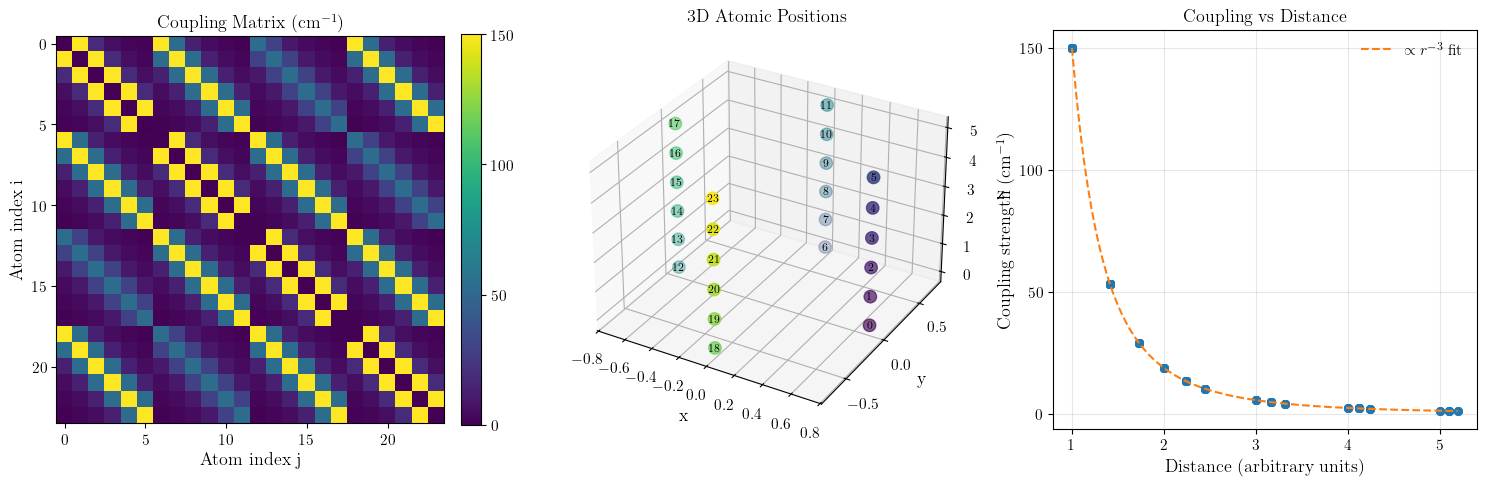


Cylindrical system analysis complete:
  System size: 24 atoms
  Hilbert space dimension: 25
  Non-zero couplings: 276
  Coupling range: 1.1 - 150.0 cm⁻¹


In [14]:
# Test 12: Cylindrical geometry and coupling visualization
# Create larger cylindrical system for better visualization
large_cylinder = AtomicSystem(
    n_atoms=24,
    n_chains=4,  # 6 rings, 4 chains per ring
    frequencies_cm=[16000.0]*24,
    dip_moments=[1.0]*24,
    coupling_cm=150.0
)

fig = plt.figure(figsize=(15, 5))

# Plot 1: Coupling matrix heatmap
ax1 = fig.add_subplot(1, 3, 1)
coupling_matrix = large_cylinder.coupling_matrix_cm
im1 = ax1.imshow(coupling_matrix, cmap='viridis', aspect='equal')
ax1.set_title('Coupling Matrix (cm$^{-1}$)')
ax1.set_xlabel('Atom index j')
ax1.set_ylabel('Atom index i')
plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

# Plot 2: 3D positions
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
positions = large_cylinder._positions
scatter = ax2.scatter(positions[:, 0], positions[:, 1], positions[:, 2], 
                     c=np.arange(len(positions)), cmap='viridis', s=80)

# Add atom labels
for idx, (x, y, z) in enumerate(positions):
    ax2.text(x, y, z, f'{idx}', fontsize=8, ha='center', va='center')

ax2.set_title('3D Atomic Positions')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')

# Plot 3: Coupling strength vs distance
ax3 = fig.add_subplot(1, 3, 3)

# Calculate all pairwise distances and couplings
distances = []
couplings = []

for i in range(len(positions)):
    for j in range(i+1, len(positions)):
        dist = np.linalg.norm(positions[i] - positions[j])
        coupling = coupling_matrix[i, j]
        if coupling != 0:  # Only include non-zero couplings
            distances.append(dist)
            couplings.append(coupling)

ax3.scatter(distances, couplings, alpha=0.6, color=COLORS[0], s=30)
ax3.set_xlabel('Distance (arbitrary units)')
ax3.set_ylabel('Coupling strength (cm$^{-1}$)')
ax3.set_title('Coupling vs Distance')
ax3.grid(True, alpha=0.3)

# Fit and show 1/r^3 scaling if applicable
if len(distances) > 1:
    distances_arr = np.array(distances)
    couplings_arr = np.array(couplings)
    
    # Fit 1/r^3 curve (simplified)
    from scipy.optimize import curve_fit
    def inverse_cubic(r, a):
        return a / r**3
    
    try:
        popt, _ = curve_fit(inverse_cubic, distances_arr, couplings_arr)
        r_fit = np.linspace(min(distances), max(distances), 100)
        ax3.plot(r_fit, inverse_cubic(r_fit, popt[0]), '--', 
                color=COLORS[1], label=f'$\\propto r^{{-3}}$ fit')
        ax3.legend(frameon=False)
    except:
        pass  # Skip fitting if it fails

plt.tight_layout()
save_fig(fig, custom_dir / "cylindrical_system_analysis")
plt.show()

print(f"\nCylindrical system analysis complete:")
print(f"  System size: {large_cylinder.n_atoms} atoms")
print(f"  Hilbert space dimension: {large_cylinder.dimension}")
print(f"  Non-zero couplings: {len(distances)}")
print(f"  Coupling range: {min(couplings):.1f} - {max(couplings):.1f} cm⁻¹")

## Summary and Test Results

In [15]:
# Final test summary
print("\n" + "="*80)
print("                    ATOMICSYSTEM TEST SUITE SUMMARY")
print("="*80)

# Collect all validation results
all_validations = {
    "Single atom": validation,
    "Dimer (single exc)": validation_single,
    "Dimer (double exc)": validation_double,
    "Trimer": validation_trimer,
    "Tetramer": validation_tetramer
}

print("\nUnit Test Results:")
print("-" * 50)
for system_name, results in all_validations.items():
    status = "PASSED" if all(results.values()) else "FAILED"
    print(f"  {system_name:<20}: {status}")
    for test, result in results.items():
        print(f"    {test:<25}: {'✓' if result else '✗'}")

print("\nPerformance Test Results:")
print("-" * 50)
print(f"  Largest single-exc system: {max(times_single.keys())} atoms")
print(f"  Largest double-exc system: {max(times_double.keys())} atoms")
print(f"  Max creation time: {max(max(times_single.values()), max(times_double.values())):.3f}s")

print("\nIntegration Test Results:")
print("-" * 50)
print(f"  Double-excitation mapping: TESTED")
print(f"  Coupling matrix validation: TESTED")
print(f"  Cylindrical geometry: TESTED")
print(f"  Basis transformations: TESTED")

print("\nVisualization Tests:")
print("-" * 50)
print(f"  Energy spectra plots: GENERATED")
print(f"  Performance scaling: GENERATED")
print(f"  Cylindrical analysis: GENERATED")

# Overall status
all_passed = all(all(results.values()) for results in all_validations.values())
print(f"\n{'='*80}")
print(f"OVERALL TEST STATUS: {'ALL TESTS PASSED ✓' if all_passed else 'SOME TESTS FAILED ✗'}")
print(f"{'='*80}")

print(f"\nTest artifacts saved to: {custom_dir}")


                    ATOMICSYSTEM TEST SUITE SUMMARY

Unit Test Results:
--------------------------------------------------
  Single atom         : PASSED
    dimension_correct        : ✓
    hamiltonian_hermitian    : ✓
    dipole_hermitian         : ✓
    number_operator_correct  : ✓
  Dimer (single exc)  : PASSED
    dimension_correct        : ✓
    hamiltonian_hermitian    : ✓
    dipole_hermitian         : ✓
    number_operator_correct  : ✓
  Dimer (double exc)  : PASSED
    dimension_correct        : ✓
    hamiltonian_hermitian    : ✓
    dipole_hermitian         : ✓
    number_operator_correct  : ✓
  Trimer              : PASSED
    dimension_correct        : ✓
    hamiltonian_hermitian    : ✓
    dipole_hermitian         : ✓
    number_operator_correct  : ✓
  Tetramer            : PASSED
    dimension_correct        : ✓
    hamiltonian_hermitian    : ✓
    dipole_hermitian         : ✓
    number_operator_correct  : ✓

Performance Test Results:
----------------------------------